### Homework 20
Veranika Ivanoyskaya
25.01.2024
v/1

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits

# Загрузка данных
digits = load_digits()

# Массив наблюдений (картинок)
X = digits.data

# Массив истинных меток классов (цифр)
y = digits.target

# Проверка размерности X и y
print("Размерность X:", X.shape)
print("Размерность y:", y.shape)

Размерность X: (1797, 64)
Размерность y: (1797,)


Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

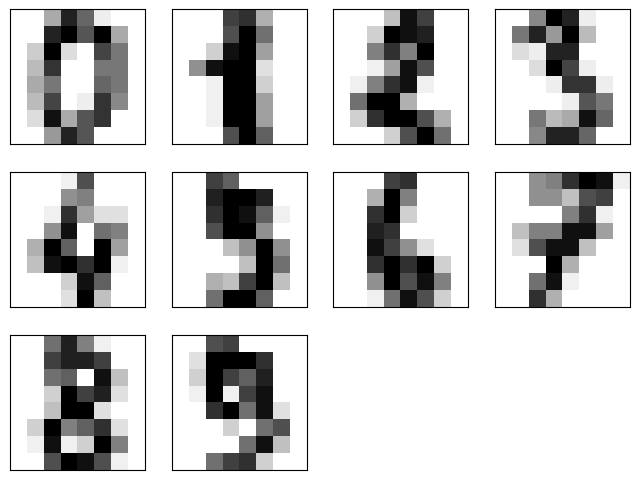

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Установка фона картинок в белый и цвета изображений в обратные
plt.figure(figsize=(8, 6))
plt.gray()  # Устанавливаем цветовую палитру в оттенки серого

# Выводим первые 10 картинок на сетке 3x4
for i in range(10):
    plt.subplot(3, 4, i + 1)  # Создаем подграфик 3x4
    plt.imshow(16 - X[i].reshape(8, 8), cmap='gray', interpolation='nearest')  # Обратные цвета
    plt.xticks([])  # Убираем деления на координатной оси x
    plt.yticks([])  # Убираем деления на координатной оси y

plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Создаем экземпляр модели для иерархической кластеризации
agg_clustering = AgglomerativeClustering(n_clusters=10)

# Выполняем кластеризацию и получаем метки кластеров
agg_cluster_labels = agg_clustering.fit_predict(X)

# Создаем экземпляр модели для метода K-средних с увеличенным числом запусков
kmeans = KMeans(n_clusters=10, n_init=100, random_state=0)

# Выполняем кластеризацию и получаем метки кластеров
kmeans_cluster_labels = kmeans.fit_predict(X)

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

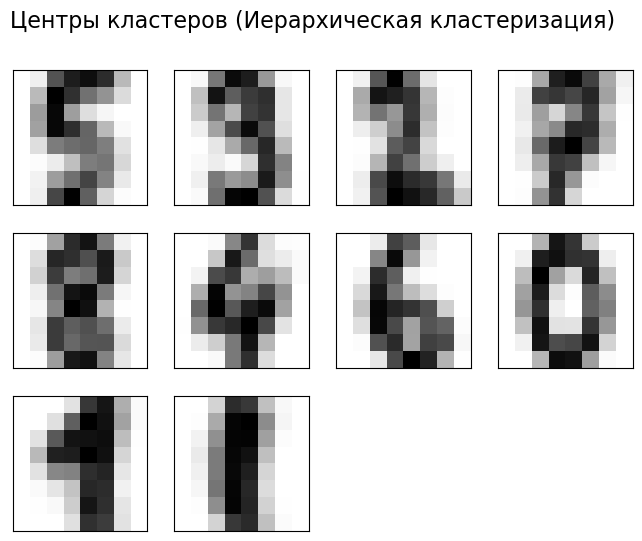

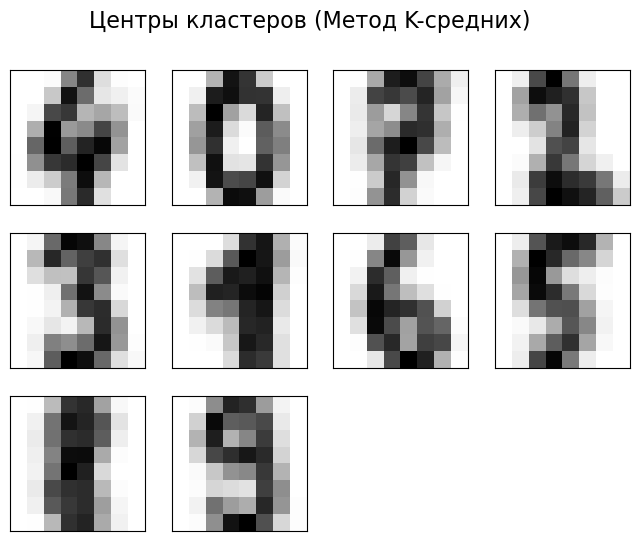

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Вычисляем центры кластеров для иерархической кластеризации
agg_cluster_centers = np.array([X[agg_cluster_labels == i].mean(axis=0) for i in range(10)])

# Визуализируем центры кластеров
plt.figure(figsize=(8, 6))
plt.gray()
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.imshow(16 - agg_cluster_centers[i].reshape(8, 8), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Центры кластеров (Иерархическая кластеризация)", fontsize=16)
plt.show()

# Вычисляем центры кластеров для метода K-средних
kmeans_cluster_centers = kmeans.cluster_centers_

# Визуализируем центры кластеров
plt.figure(figsize=(8, 6))
plt.gray()
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.imshow(16 - kmeans_cluster_centers[i].reshape(8, 8), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Центры кластеров (Метод K-средних)", fontsize=16)
plt.show()

комментарий: 
два алгоритма дают похожий результат, в этом случае визуально результаты выглядят равноценно схожими

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

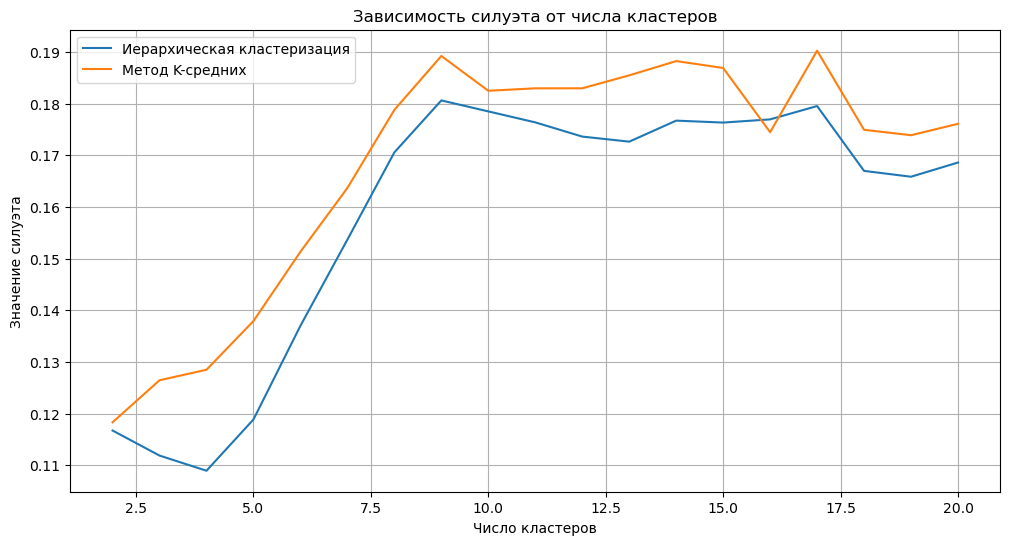

In [5]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Создаем списки для хранения значений силуэта для каждого числа кластеров
silhouette_scores_agg = []
silhouette_scores_kmeans = []

# Перебираем числа кластеров от 2 до 20
for n_clusters in range(2, 21):
    # Иерархическая кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_cluster_labels = agg_clustering.fit_predict(X)
    silhouette_agg = silhouette_score(X, agg_cluster_labels)
    silhouette_scores_agg.append(silhouette_agg)

    # Метод K-средних
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=0)
    kmeans_cluster_labels = kmeans.fit_predict(X)
    silhouette_kmeans = silhouette_score(X, kmeans_cluster_labels)
    silhouette_scores_kmeans.append(silhouette_kmeans)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(range(2, 21), silhouette_scores_agg, label="Иерархическая кластеризация")
plt.plot(range(2, 21), silhouette_scores_kmeans, label="Метод K-средних")
plt.xlabel("Число кластеров")
plt.ylabel("Значение силуэта")
plt.legend(loc="best")
plt.title("Зависимость силуэта от числа кластеров")
plt.grid(True)
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

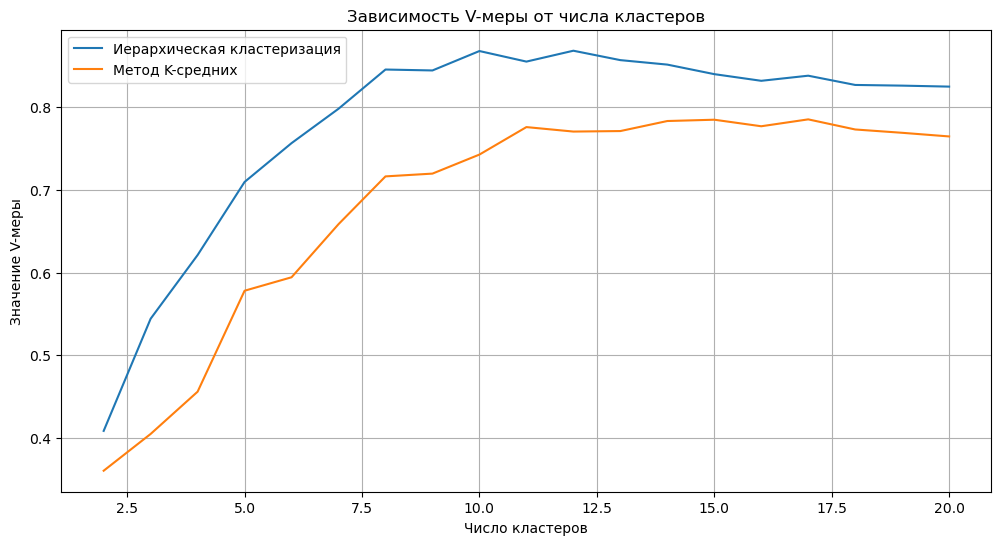

In [6]:
from sklearn.metrics import v_measure_score

# Создаем списки для хранения значений V-меры для каждого числа кластеров
v_measure_scores_agg = []
v_measure_scores_kmeans = []

# Перебираем числа кластеров от 2 до 20
for n_clusters in range(2, 21):
    # Иерархическая кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_cluster_labels = agg_clustering.fit_predict(X)
    v_measure_agg = v_measure_score(y, agg_cluster_labels)
    v_measure_scores_agg.append(v_measure_agg)

    # Метод K-средних
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=0)
    kmeans_cluster_labels = kmeans.fit_predict(X)
    v_measure_kmeans = v_measure_score(y, kmeans_cluster_labels)
    v_measure_scores_kmeans.append(v_measure_kmeans)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(range(2, 21), v_measure_scores_agg, label="Иерархическая кластеризация")
plt.plot(range(2, 21), v_measure_scores_kmeans, label="Метод K-средних")
plt.xlabel("Число кластеров")
plt.ylabel("Значение V-меры")
plt.legend(loc="best")
plt.title("Зависимость V-меры от числа кластеров")
plt.grid(True)
plt.show()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, v_measure_score

# Список для хранения результатов
results = []

# Перебираем разное число новых признаков
for n_components in [2, 5, 10, 20]:
    # Выполняем сингулярное разложение
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_svd = svd.fit_transform(X)
    
    # Иерархическая кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=10)
    agg_cluster_labels = agg_clustering.fit_predict(X_svd)
    
    # Метод K-средних
    kmeans = KMeans(n_clusters=10, n_init=100, random_state=0)
    kmeans_cluster_labels = kmeans.fit_predict(X_svd)
    
    # Вычисляем силуэт и V-меру
    silhouette_agg = silhouette_score(X_svd, agg_cluster_labels)
    v_measure_agg = v_measure_score(y, agg_cluster_labels)
    silhouette_kmeans = silhouette_score(X_svd, kmeans_cluster_labels)
    v_measure_kmeans = v_measure_score(y, kmeans_cluster_labels)
    
    # Сохраняем результаты
    results.append({
        'n_components': n_components,
        'silhouette_agg': silhouette_agg,
        'v_measure_agg': v_measure_agg,
        'silhouette_kmeans': silhouette_kmeans,
        'v_measure_kmeans': v_measure_kmeans
    })

# Выводим результаты
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

   n_components  silhouette_agg  v_measure_agg  silhouette_kmeans  \
0             2        0.280817       0.333719           0.349169   
1             5        0.272742       0.675604           0.312177   
2            10        0.250713       0.825975           0.263190   
3            20        0.195661       0.817131           0.212790   

   v_measure_kmeans  
0          0.347268  
1          0.634967  
2          0.720355  
3          0.742273  


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

C:\Users\veran\AppData\Local\Temp\ipykernel_21000\2633908103.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 10), marker="o")


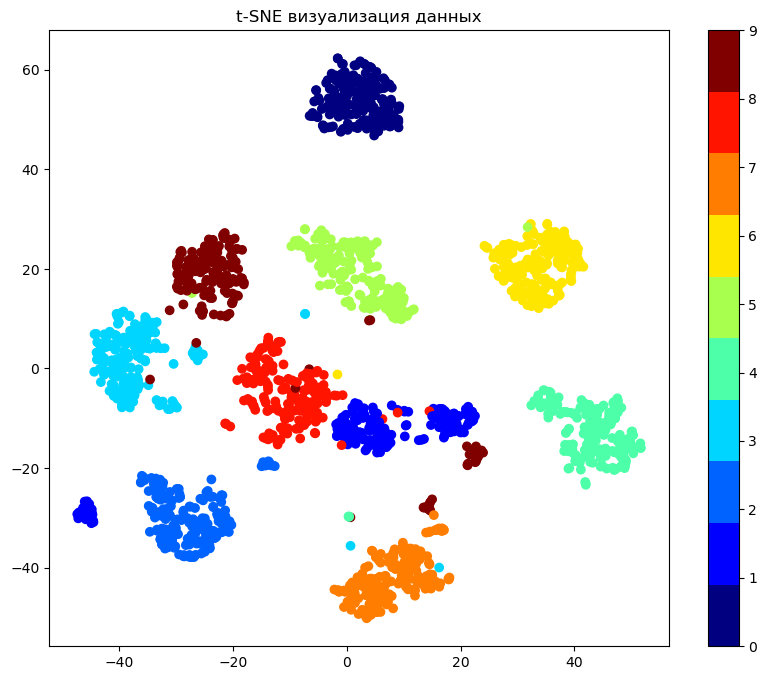

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Выполняем t-SNE преобразование
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Визуализация данных
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap("jet", 10), marker="o")
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE визуализация данных")
plt.show()

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [9]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, v_measure_score

# Иерархическая кластеризация
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_cluster_labels = agg_clustering.fit_predict(X_tsne)

# Метод K-средних
kmeans = KMeans(n_clusters=10, n_init=100, random_state=0)
kmeans_cluster_labels = kmeans.fit_predict(X_tsne)

# Вычисляем силуэт и V-меру
silhouette_agg = silhouette_score(X_tsne, agg_cluster_labels)
v_measure_agg = v_measure_score(y, agg_cluster_labels)
silhouette_kmeans = silhouette_score(X_tsne, kmeans_cluster_labels)
v_measure_kmeans = v_measure_score(y, kmeans_cluster_labels)

print(f"Силуэт (Agglomerative Clustering): {silhouette_agg}")
print(f"V-мера (Agglomerative Clustering): {v_measure_agg}")
print(f"Силуэт (K-Means): {silhouette_kmeans}")
print(f"V-мера (K-Means): {v_measure_kmeans}")

Силуэт (Agglomerative Clustering): 0.6391013264656067
V-мера (Agglomerative Clustering): 0.911056555346593
Силуэт (K-Means): 0.6427107453346252
V-мера (K-Means): 0.9116334462095017


Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

C:\Users\veran\AppData\Local\Temp\ipykernel_21000\810474131.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(center.reshape(8, 8), cmap=plt.cm.get_cmap("gray"))


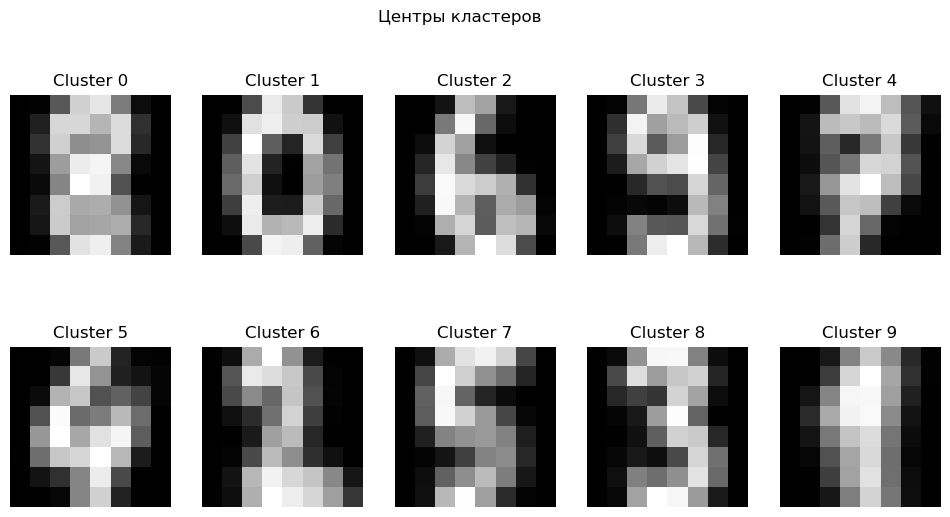

In [11]:
# Используем V-меру для выбора лучшего разбиения
best_cluster_labels = agg_cluster_labels if v_measure_agg > v_measure_kmeans else kmeans_cluster_labels

# Создадим DataFrame с данными и метками кластеров
import pandas as pd
data_df = pd.DataFrame(X)
data_df['cluster'] = best_cluster_labels

# Определим центры кластеров
cluster_centers = data_df.groupby('cluster').mean().values

# Визуализируем центры кластеров как изображения
plt.figure(figsize=(12, 6))
for i, center in enumerate(cluster_centers):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center.reshape(8, 8), cmap=plt.cm.get_cmap("gray"))
    plt.title(f'Cluster {i}')
    plt.axis('off')

plt.suptitle('Центры кластеров')
plt.show()

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

###### В ходе выполнения работы были получены следующие выводы:

Сравнение иерархической кластеризации и алгоритма K-средних:

Оба метода, иерархическая кластеризация и алгоритм K-средних, способны создавать осмысленные кластеры. 
Их качество может зависеть от разных настроек и критериев оценивания.
Выбор лучшего метода кластеризации может зависеть от используемых метрик оценивания качества (силуэт и V-мера). 
Например, в данной задаче алгоритм K-средних показал более высокие значения силуэта, 
в то время как иерархическая кластеризация показала более высокие значения V-меры. 
Это свидетельствует о том, что лучший метод может зависеть от конкретных целей задачи.
Настройка параметров каждого метода также может влиять на качество разбиения.

Снижение размерности признакового пространства:
снижение размерности признакового пространства до двух признаков с помощью t-SNE позволило сохранить более высокое качество кластеризации (высокие значения силуэта и V-меры) по сравнению с исходными данными.
В данном случае снижение размерности признакового пространства с использованием t-SNE привело к лучшей интерпретируемости данных и улучшению качества кластеризации.